In this notebook we visualize the similarity plot of the positional embeddings for the various varaints of ViTs.

In [1]:
import tensorflow as tf 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## ViTs

In [2]:
with tf.io.gfile.GFile("gs://vit_models/augreg/index.csv") as f:
    df = pd.read_csv(f)

In [3]:
# ViT Base 16
b16s = df.query(
    'ds=="i21k" & adapt_resolution==224 & adapt_ds=="imagenet2012" & name=="B/16"'
).sort_values("adapt_final_test", ascending=False)

best_b16_i1k_checkpoint = str(b16s.iloc[0]["adapt_filename"])

In [4]:
filename_b16 = best_b16_i1k_checkpoint
path_b16 = f"gs://vit_models/augreg/{filename_b16}.npz"
print(f"{tf.io.gfile.stat(path_b16).length / 1024 / 1024:.1f} MiB - {path_b16}")

330.3 MiB - gs://vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium2-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz


In [5]:
!gsutil cp {path_b16} .
local_path_b16 = path_b16.split("//")[-1].split("/")[-1]
local_path_b16

Copying gs://vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium2-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz...
- [1 files][330.3 MiB/330.3 MiB]                                                
Operation completed over 1 objects/330.3 MiB.                                    


'B_16-i21k-300ep-lr_0.001-aug_medium2-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'

In [6]:
# ViT Large 16
l16s = df.query(
    'ds=="i21k" & adapt_resolution==224 & adapt_ds=="imagenet2012" & name=="L/16"'
).sort_values("adapt_final_test", ascending=False)

best_l16_i1k_checkpoint = str(l16s.iloc[0]["adapt_filename"])

In [7]:
filename_l16 = best_l16_i1k_checkpoint
path_l16 = f"gs://vit_models/augreg/{filename_l16}.npz"
print(f"{tf.io.gfile.stat(path_l16).length / 1024 / 1024:.1f} MiB - {path_b16}")

1161.0 MiB - gs://vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium2-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz


In [8]:
!gsutil cp {path_l16} .
local_path_l16 = path_l16.split("//")[-1].split("/")[-1]
local_path_l16

Copying gs://vit_models/augreg/L_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_224.npz...
/ [1 files][  1.1 GiB/  1.1 GiB]   29.6 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


'L_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_224.npz'

In [9]:
def plot_similarity_vit(local_path):
    with open(local_path, "rb") as f:
        params_jax = np.load(f)
        params_jax = dict(
            zip(params_jax.keys(), params_jax.values())
        )
    for k in params_jax:
        if "pos" in k: 
            pos_embed_key = k
    position_embeddings = params_jax[pos_embed_key][0][1:, ...]
    similarity = position_embeddings @ position_embeddings.T
    plt.imshow(similarity, cmap="inferno")
    plt.show()

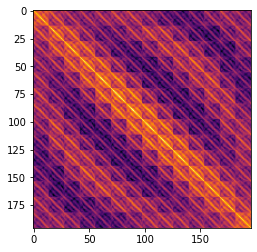

In [10]:
# ViT B 16
plot_similarity_vit(local_path_b16)

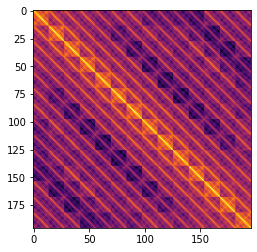

In [11]:
# ViT L 16
plot_similarity_vit(local_path_l16)

### Observations:

- Each position is the most similar to itself. This is evident with the main diagonal.
- There is a recurring diagonal pattern which showcases the sinusoidal behaviour of the positional embeddings.
- [Vaswani et. al.](https://arxiv.org/abs/1706.03762) had suggested a sinusoidal postional embedding scheme which is intuitively what the learned positional embeddings achieve.
- With the larger model (L/16) the positional embeddings are sharper, which signifies a better learning.

## DeiT

In [12]:
deit_b16_gcs_path = "gs://tfhub-modules/sayakpaul/deit_base_patch16_224/1/uncompressed"
deit_b16_distilled_gcs_path = "gs://tfhub-modules/sayakpaul/deit_base_distilled_patch16_224/1/uncompressed"

deit_b16 = tf.keras.models.load_model(deit_b16_gcs_path)
deit_b16_distilled = tf.keras.models.load_model(deit_b16_distilled_gcs_path)

dummy_inputs = tf.ones((2, 224, 224, 3))

_ = deit_b16(dummy_inputs)
_ = deit_b16_distilled(dummy_inputs)

In [13]:
def plot_similarity_deit(model, distilled=False):
    if distilled:
        pos_embeds = model.positional_embedding[0][2:, ...]
    else:
        pos_embeds = model.positional_embedding[0][1:, ...]
    similarity = tf.matmul(
        a=pos_embeds,
        b=pos_embeds,
        transpose_b=True)
    plt.imshow(similarity, cmap="inferno")
    plt.show()

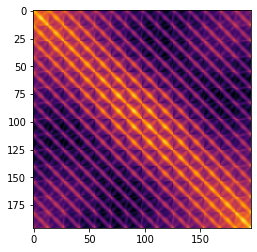

In [14]:
plot_similarity_deit(deit_b16)

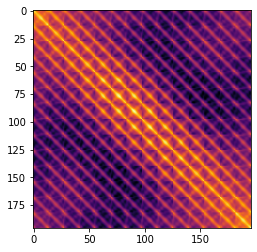

In [15]:
plot_similarity_deit(deit_b16_distilled, distilled=True)

### Observations:
- The main diagonal of the DeiT is thicker than that of ViT. This means that the positions nearby are very similar. eg. the 5th position is close to the 3rd and the 4th. The thicker the main diagonal is, the wider the range of similar postions we get.

## DINO

In [16]:
import torch

In [17]:
dino_s16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_b16 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')

Downloading: "https://github.com/facebookresearch/dino/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_vitbase16_pretrain.pth


  0%|          | 0.00/327M [00:00<?, ?B/s]

In [18]:
def plot_similarity_dino(model):
    pos_embed = model.pos_embed[0, 1:, ...].detach().numpy()
    similarity = pos_embed @ pos_embed.T
    plt.imshow(similarity, cmap="inferno")
    plt.show()

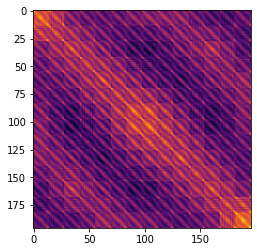

In [19]:
plot_similarity_dino(dino_s16)

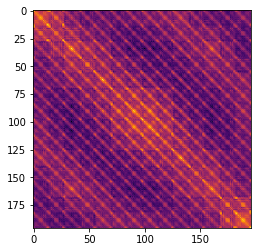

In [20]:
plot_similarity_dino(dino_b16)

### Observations:
- The mian diagonal is thick.
- We can see here that the small and the base model have a very similar positional embedding space.